In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [5]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch CUDA available: False


In [4]:
# Uninstall current PyTorch first
!pip uninstall torch torchvision torchaudio -y

# Install PyTorch with CUDA 12.1 (matching your driver's CUDA 13.0)
!pip install torch --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.10.0
Uninstalling torch-2.10.0:
  Successfully uninstalled torch-2.10.0
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 119.9 MB/s  0:00:0400:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 179.3 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 110.8 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 174.0 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 127.9 MB/s  0:00:0300:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 147.6 MB/s  0:00:0200:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 169.8 MB/s  0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 185.5 MB/s  0:00:00eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 181.3 MB/s  0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19

In [6]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121


In [7]:
!pip install torch --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)


In [3]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch CUDA available: True
GPU: NVIDIA A100-SXM4-40GB MIG 1g.5gb


In [45]:
import numpy as np
import pandas as pd

DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics rebuild ----------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def mass(Z,A): 
    return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
v_over_c = np.sqrt(np.clip(2*df["E c.m."].values/(mu_red+epsilon),0,np.inf))
df["eta"] = (df["Z1"]*df["Z2"]) / ((1/137.036)*(v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# Coulomb barrier
barrier_df = df.groupby("Reaction").first().reset_index()
barrier_df["V_B"] = (barrier_df["Z1"]*barrier_df["Z2"]*1.44) / barrier_df["R B"]
df = df.merge(barrier_df[["Reaction","V_B"]], on="Reaction", how="left")




# Coulomb parameter
v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# S-factor logs
log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

print("delta_log10_S created.")
print("Dataset ready.")
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]


delta_log10_S created.
Dataset ready.


In [46]:
import pennylane as qml
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

# ---------- Device setup ----------
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch_device)

# ---------- Hyperparameters (adjust these to scale up) ----------
n_qubits = 14                # Increase from 10 to 12 (or 14)
n_layers = 12                # Increase from 8 to 10 (or 12)
batch_size = 64              # Can increase to 128 if GPU memory allows
learning_rate = 1e-3
epochs = 100                 # Max epochs (early stopping will stop earlier)
patience = 10                # Stop if no improvement for 15 epochs

# PennyLane device (default.qubit with backprop – uses GPU automatically if tensors are on GPU)
dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("lightning.gpu", wires=n_qubits)

Using device: cuda


In [47]:
@qml.qnode(dev, interface="torch", diff_method="backprop")
# @qml.qnode(dev, interface="torch", diff_method="adjoint")
def qnode_single(weights, x):
    """
    weights: (n_layers, n_qubits, 3)
    x: (n_qubits,) – one sample
    """
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [48]:
class QuantumRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = nn.Linear(in_dim, n_qubits)
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits, 3))
        self.fc1 = nn.Linear(n_qubits, 16)          # smaller head
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.float()
        x_enc = torch.tanh(self.encoder(x))
        q_out_tuple = qnode_single(self.q_weights, x_enc)
        q_out = torch.stack(q_out_tuple, dim=1)
        q_out = q_out.to(x.dtype)
        h = torch.relu(self.fc1(q_out))
        h = self.dropout(h)
        out = self.fc2(h)
        return out

In [49]:

# Extract X and y
X = df[features_train].values.astype(np.float32)
y = df["delta_log10_S"].values.astype(np.float32).reshape(-1, 1)

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reaction‑wise split (load your split files)
OUTDIR_BASE = "mdn_70_10_20_optimized"   # <--- ADJUST IF NEEDED
train_reacts = pd.read_csv(f"{OUTDIR_BASE}/train_reactions.csv")["Reaction"].values
val_reacts   = pd.read_csv(f"{OUTDIR_BASE}/val_reactions.csv")["Reaction"].values
test_reacts  = pd.read_csv(f"{OUTDIR_BASE}/test_reactions.csv")["Reaction"].values

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

X_train = X_scaled[train_mask]
y_train = y[train_mask]
X_val   = X_scaled[val_mask]
y_val   = y[val_mask]
X_test  = X_scaled[test_mask]
y_test  = y[test_mask]

# Convert to torch tensors (CPU initially)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Val samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train samples: 2493, Val samples: 354, Test samples: 685
Train batches: 39, Val batches: 6, Test batches: 11


In [15]:
model = QuantumRegressor(in_dim=29).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

print("Model parameters device:", next(model.parameters()).device)  # Should be cuda:0

Model parameters device: cuda:0


/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
for epoch in range(epochs):
    # ---------- Training ----------
    model.train()
    train_loss = 0.0
    start_time = time.time()

    for xb, yb in train_loader:
        xb, yb = xb.to(torch_device), yb.to(torch_device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(torch_device), yb.to(torch_device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    epoch_time = time.time() - start_time
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/{epochs} | Time: {epoch_time:.2f}s | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.2e}")

    # ---------- Early Stopping Check ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  *** New best model saved (val loss: {val_loss:.6f}) ***")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1} (best at epoch {best_epoch+1})")
            break

print("Training finished.")

Epoch   1/100 | Time: 85.06s | Train Loss: 0.080146 | Val Loss: 0.103532 | LR: 1.00e-03
  *** New best model saved (val loss: 0.103532) ***
Epoch   2/100 | Time: 84.97s | Train Loss: 0.077148 | Val Loss: 0.103223 | LR: 1.00e-03
  *** New best model saved (val loss: 0.103223) ***
Epoch   3/100 | Time: 84.88s | Train Loss: 0.074725 | Val Loss: 0.102473 | LR: 1.00e-03
  *** New best model saved (val loss: 0.102473) ***
Epoch   4/100 | Time: 84.74s | Train Loss: 0.072176 | Val Loss: 0.102248 | LR: 1.00e-03
  *** New best model saved (val loss: 0.102248) ***
Epoch   5/100 | Time: 84.84s | Train Loss: 0.070923 | Val Loss: 0.101738 | LR: 1.00e-03
  *** New best model saved (val loss: 0.101738) ***
Epoch   6/100 | Time: 84.98s | Train Loss: 0.068717 | Val Loss: 0.102817 | LR: 1.00e-03
Epoch   7/100 | Time: 84.76s | Train Loss: 0.066661 | Val Loss: 0.101066 | LR: 1.00e-03
  *** New best model saved (val loss: 0.101066) ***
Epoch   8/100 | Time: 84.91s | Train Loss: 0.064587 | Val Loss: 0.101963

In [17]:
# Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Evaluate on test set
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(torch_device), yb.to(torch_device)
        preds = model(xb)
        loss = criterion(preds, yb)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f"Test Loss (best model): {test_loss:.6f}")

/tmp/ipykernel_39806/1556161386.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Test Loss (best model): 0.043511


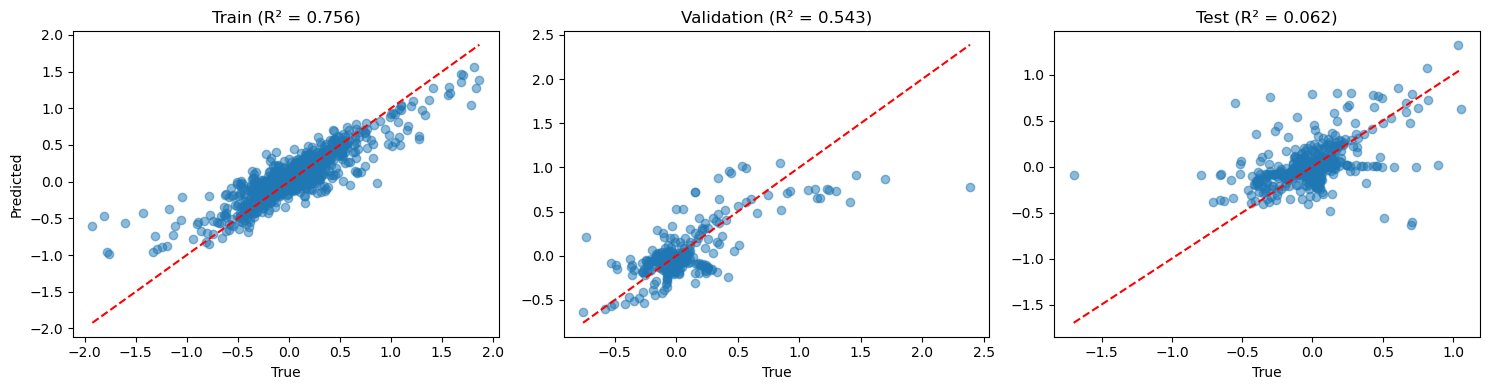

In [18]:
# Collect predictions for train/val/test
model.eval()
with torch.no_grad():
    train_pred = model(X_train_t.to(torch_device)).cpu().numpy()
    val_pred   = model(X_val_t.to(torch_device)).cpu().numpy()
    test_pred  = model(X_test_t.to(torch_device)).cpu().numpy()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(y_train, train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"Train (R² = {1 - np.var(y_train - train_pred)/np.var(y_train):.3f})")

plt.subplot(1,3,2)
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True")
plt.title(f"Validation (R² = {1 - np.var(y_val - val_pred)/np.var(y_val):.3f})")

plt.subplot(1,3,3)
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True")
plt.title(f"Test (R² = {1 - np.var(y_test - test_pred)/np.var(y_test):.3f})")

plt.tight_layout()
plt.show()

In [19]:
# ============================================================
# LOAD BEST MODEL
# ============================================================

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate_model(loader, name):
    preds = []
    truth = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(torch_device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            truth.append(yb.numpy())
    
    preds = np.vstack(preds)
    truth = np.vstack(truth)
    
    mse = mean_squared_error(truth, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(truth, preds)
    
    print(f"\n{name} RESULTS")
    print(f"MSE  : {mse:.6f}")
    print(f"RMSE : {rmse:.6f}")
    print(f"R2   : {r2:.6f}")
    
    return r2, rmse


# ============================================================
# EVALUATE
# ============================================================

r2_train, rmse_train = evaluate_model(train_loader, "TRAIN")
r2_val, rmse_val     = evaluate_model(val_loader, "VALIDATION")
r2_test, rmse_test   = evaluate_model(test_loader, "TEST")

/tmp/ipykernel_39806/798825926.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))



TRAIN RESULTS
MSE  : 0.019224
RMSE : 0.138652
R2   : 0.753941

VALIDATION RESULTS
MSE  : 0.049937
RMSE : 0.223467
R2   : 0.538344

TEST RESULTS
MSE  : 0.044259
RMSE : 0.210378
R2   : 0.055736


In [20]:
# ==============================================
# LOAD BEST MODEL
# ==============================================

model = QuantumRegressor(in_dim=29)
model.load_state_dict(torch.load("best_model.pt", map_location=torch_device))
model.eval()
model.to(torch_device)

print("Best model loaded.")

Best model loaded.


/tmp/ipykernel_39806/1470981669.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=torch_device))


In [21]:
# ==============================================
# EXTRACT QUANTUM EMBEDDINGS
# ==============================================

def extract_quantum_embeddings(model, X_tensor):
    
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in range(len(X_tensor)):
            
            x = X_tensor[i:i+1].to(torch_device)
            
            # Classical encoder
            x_enc = torch.tanh(model.encoder(x))
            
            # Quantum expectation values
            q_out_tuple = qnode_single(model.q_weights, x_enc)
            q_out = torch.stack(q_out_tuple, dim=1)
            
            embeddings.append(q_out.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    
    return embeddings


# Extract for entire dataset
X_all_tensor = torch.tensor(X_scaled, dtype=torch.float32)
quantum_embeddings = extract_quantum_embeddings(model, X_all_tensor)

print("Quantum embedding shape:", quantum_embeddings.shape)

Quantum embedding shape: (3532, 14)


In [22]:
# ==============================================
# REACTION-LEVEL QUANTUM EMBEDDING
# ==============================================

import pandas as pd
import numpy as np

# Attach embeddings to dataframe
df_embeddings = df.copy()
df_embeddings["Reaction"] = df["Reaction"]
df_embeddings["V_B"] = df["V_B"]

for i in range(quantum_embeddings.shape[1]):
    df_embeddings[f"q_{i}"] = quantum_embeddings[:, i]

# Compute reaction-level mean embedding
reaction_embeddings = (
    df_embeddings
    .groupby("Reaction")
    [[f"q_{i}" for i in range(quantum_embeddings.shape[1])]]
    .mean()
    .reset_index()
)

print("Reaction-level embedding shape:", reaction_embeddings.shape)
reaction_embeddings.head()

Reaction-level embedding shape: (213, 15)


,Reaction,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,q_10,q_11,q_12,q_13
0,12 C + 144 Sm,0.265336,0.216639,0.087111,0.130454,0.066586,0.116661,0.214980,0.252905,0.264708,0.017662,0.280483,0.066825,0.037565,0.114544
1,12 C + 152 Sm,0.385774,0.256353,0.095079,0.076788,0.086953,0.361800,0.258895,0.171683,0.416648,0.029496,0.102974,0.093761,0.065831,0.170973
2,12 C + 154 Sm,0.382764,0.270753,0.075972,0.114813,0.108913,0.301570,0.235897,0.194959,0.390647,0.073221,0.114821,0.123754,0.082360,0.182319
3,12 C + 181 Ta,0.186351,0.078608,0.034009,0.023926,0.019399,0.247761,0.155328,0.071918,0.201589,0.034547,0.040376,0.007361,0.003675,0.055813
4,12 C + 194 Pt,0.217589,0.240706,0.109529,0.124522,0.139074,0.218220,0.214405,0.359629,0.295569,0.024411,0.200548,0.075038,0.093644,0.245325


In [23]:
# ==============================================
# QUANTUM DISTANCE MATRIX
# ==============================================

from sklearn.metrics import pairwise_distances

reaction_names = reaction_embeddings["Reaction"].values
Q_matrix = reaction_embeddings[[f"q_{i}" for i in range(14)]].values

# Euclidean distance
quantum_distance = pairwise_distances(Q_matrix, metric="euclidean")

print("Distance matrix shape:", quantum_distance.shape)
print("Distance min:", quantum_distance.min())
print("Distance max:", quantum_distance.max())

Distance matrix shape: (213, 213)
Distance min: 0.0
Distance max: 1.8524904858340674


In [25]:
# ==============================================
# LOAD CLASSICAL MDN ENSEMBLE (FOR SWITCH)
# ==============================================

import os
import numpy as np

OUTDIR_BASE = "mdn_70_10_20_optimized"
ENSEMBLE_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

seed_dirs = sorted([
    os.path.join(ENSEMBLE_DIR, d)
    for d in os.listdir(ENSEMBLE_DIR)
    if d.startswith("seed_")
])

all_seed_components = []

for seed_path in seed_dirs:
    
    npz_path = os.path.join(seed_path, "mdn_all_components.npz")
    
    if not os.path.exists(npz_path):
        continue
    
    data = np.load(npz_path)
    
    all_seed_components.append({
        "pi": data["pi"]
    })

print("Loaded seeds:", len(all_seed_components))

Loaded seeds: 10


In [26]:
# ==========================================================
# RECOMPUTE ROBUST x_switch (CLASSICAL MDN)
# ==========================================================

import numpy as np
import pandas as pd

# ----------------------------------------------------
# Helper — compute switch for ONE seed
# ----------------------------------------------------

def compute_switch_per_seed(df, pi_array):
    
    df_temp = df.copy().reset_index(drop=True)
    df_temp["dominant"] = np.argmax(pi_array, axis=1)
    
    switch_dict = {}
    
    for reaction, sub in df_temp.groupby("Reaction"):
        
        sub = sub.sort_values("E c.m.").reset_index(drop=True)
        
        dom = sub["dominant"].values
        E_vals = sub["E c.m."].values
        
        if len(dom) < 2:
            continue
        
        switch_energy = np.nan
        
        for i in range(1, len(dom)):
            if dom[i] != dom[i-1]:
                switch_energy = E_vals[i]
                break
        
        if not np.isnan(switch_energy):
            
            V_B = sub["V_B"].iloc[0]
            x_switch = switch_energy / V_B
            
            switch_dict[reaction] = x_switch
    
    return switch_dict


# ----------------------------------------------------
# Compute switch for ALL seeds
# ----------------------------------------------------

seed_switch_results = []

for seed_data in all_seed_components:
    
    pi_all = seed_data["pi"]
    switch_dict = compute_switch_per_seed(df, pi_all)
    seed_switch_results.append(switch_dict)

print("Switch computed for", len(seed_switch_results), "seeds.")


# ----------------------------------------------------
# Aggregate across seeds
# ----------------------------------------------------

all_reactions = df["Reaction"].unique()

switch_records = []

for reaction in all_reactions:
    
    x_list = []
    
    for seed_dict in seed_switch_results:
        if reaction in seed_dict:
            x_list.append(seed_dict[reaction])
    
    n_valid = len(x_list)
    
    if n_valid > 0:
        switch_records.append({
            "Reaction": reaction,
            "x_switch_mean": np.mean(x_list),
            "x_switch_std": np.std(x_list),
            "seed_fraction": n_valid / len(seed_switch_results)
        })

switch_df = pd.DataFrame(switch_records)

# ----------------------------------------------------
# Reliability classification (>= 80% seeds)
# ----------------------------------------------------

switch_df["reliable"] = switch_df["seed_fraction"] >= 0.8

switch_df_clean = switch_df[switch_df["reliable"]].copy()

print("Total reactions with switch:", len(switch_df))
print("Reliable reactions:", len(switch_df_clean))
switch_df_clean.head()

Switch computed for 10 seeds.
Total reactions with switch: 208
Reliable reactions: 137


,Reaction,x_switch_mean,x_switch_std,seed_fraction,reliable
0,12 C + 89 Y,0.911966,0.026922,1.0,True
1,12 C + 92 Zr,0.915604,0.017499,1.0,True
2,12 C + 144 Sm,0.925802,0.022091,1.0,True
6,12 C + 194 Pt,0.940973,0.018316,1.0,True
7,12 C + 198 Pt,0.936251,0.012720,1.0,True


In [27]:
# ==============================================
# MERGE QUANTUM EMBEDDING WITH x_switch
# ==============================================

reaction_embeddings = reaction_embeddings.merge(
    switch_df_clean[["Reaction", "x_switch_mean"]],
    on="Reaction",
    how="inner"
)

print("Reactions with quantum + x_switch:", reaction_embeddings.shape)
reaction_embeddings.head()

Reactions with quantum + x_switch: (137, 16)


,Reaction,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,q_10,q_11,q_12,q_13,x_switch_mean
0,12 C + 144 Sm,0.265336,0.216639,0.087111,0.130454,0.066586,0.116661,0.214980,0.252905,0.264708,0.017662,0.280483,0.066825,0.037565,0.114544,0.925802
1,12 C + 194 Pt,0.217589,0.240706,0.109529,0.124522,0.139074,0.218220,0.214405,0.359629,0.295569,0.024411,0.200548,0.075038,0.093644,0.245325,0.940973
2,12 C + 198 Pt,0.253825,0.295289,0.115439,0.090791,0.114767,0.198543,0.205237,0.389730,0.247741,0.004131,0.240679,0.058190,0.096683,0.231902,0.936251
3,12 C + 204 Pb,0.236394,0.223523,0.083252,0.088004,0.098027,0.161934,0.212284,0.445941,0.186040,0.017840,0.294336,0.041179,0.070257,0.246828,0.930299
4,12 C + 206 Pb,0.274311,0.226580,0.072887,0.050364,0.065323,0.157048,0.208260,0.374597,0.170123,-0.012534,0.300828,0.022659,0.053624,0.201055,0.948447


In [28]:
# ==============================================
# QUANTUM DISTANCE vs |Δ x_switch|
# ==============================================

import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr, spearmanr

# Extract quantum matrix (137 × 14)
Q_matrix = reaction_embeddings[[f"q_{i}" for i in range(14)]].values

# Compute pairwise quantum distances
quantum_dist = pairwise_distances(Q_matrix, metric="euclidean")

# Extract x_switch vector
x_vals = reaction_embeddings["x_switch_mean"].values

# Compute pairwise |Δ x_switch|
x_diff = np.abs(x_vals[:, None] - x_vals[None, :])

# Flatten upper triangle (avoid duplicates)
mask = np.triu(np.ones_like(quantum_dist), k=1).astype(bool)

qd_flat = quantum_dist[mask]
xd_flat = x_diff[mask]

# Correlation
pearson_corr = pearsonr(qd_flat, xd_flat)
spearman_corr = spearmanr(qd_flat, xd_flat)

print("Pearson correlation:", pearson_corr)
print("Spearman correlation:", spearman_corr)

Pearson correlation: PearsonRResult(statistic=np.float64(-0.0321490058878107), pvalue=np.float64(0.0019131771923368076))
Spearman correlation: SignificanceResult(statistic=np.float64(-0.03280167907261158), pvalue=np.float64(0.001543243532225243))


In [29]:
# ==============================================
# PCA ANALYSIS OF QUANTUM EMBEDDING
# ==============================================

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
Q_pca = pca.fit_transform(Q_matrix)

print("Explained variance ratio:", pca.explained_variance_ratio_)

pc1 = Q_pca[:,0]

from scipy.stats import pearsonr, spearmanr

print("PC1 vs x_switch Pearson:", pearsonr(pc1, x_vals))
print("PC1 vs x_switch Spearman:", spearmanr(pc1, x_vals))

Explained variance ratio: [0.66087006 0.1437657  0.05748827]
PC1 vs x_switch Pearson: PearsonRResult(statistic=np.float64(-0.29799766939094213), pvalue=np.float64(0.0004051323206143543))
PC1 vs x_switch Spearman: SignificanceResult(statistic=np.float64(-0.31351858420296075), pvalue=np.float64(0.00019108226731006313))


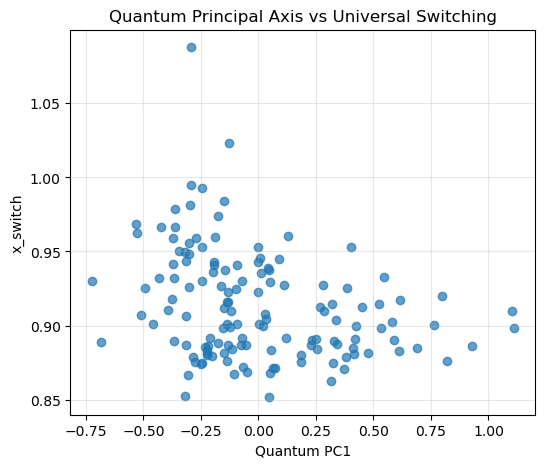

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(pc1, x_vals, alpha=0.7)
plt.xlabel("Quantum PC1")
plt.ylabel("x_switch")
plt.title("Quantum Principal Axis vs Universal Switching")
plt.grid(alpha=0.3)
plt.show()

In [31]:
# ==============================================
# MERGE STRUCTURAL PARAMETERS
# ==============================================

struct_df = df.groupby("Reaction").first().reset_index()

reaction_embeddings = reaction_embeddings.merge(
    struct_df[["Reaction", "β P", "β T", "Q ( 2 n )"]],
    on="Reaction",
    how="left"
)

reaction_embeddings["beta_eff"] = (
    reaction_embeddings["β P"].abs() +
    reaction_embeddings["β T"].abs()
)

# Extract structural arrays
beta_vals = reaction_embeddings["beta_eff"].values
Q2n_vals = reaction_embeddings["Q ( 2 n )"].values

from scipy.stats import pearsonr

print("PC1 vs beta_eff:", pearsonr(pc1, beta_vals))
print("PC1 vs Q(2n):", pearsonr(pc1, Q2n_vals))

PC1 vs beta_eff: PearsonRResult(statistic=np.float64(-0.21666709806561146), pvalue=np.float64(0.010988306840143664))
PC1 vs Q(2n): PearsonRResult(statistic=np.float64(0.12656581810733622), pvalue=np.float64(0.14054224886914893))


In [32]:
for i in range(3):
    print(f"PC{i+1} vs x_switch:", pearsonr(Q_pca[:, i], x_vals))

PC1 vs x_switch: PearsonRResult(statistic=np.float64(-0.29799766939094213), pvalue=np.float64(0.0004051323206143543))
PC2 vs x_switch: PearsonRResult(statistic=np.float64(-0.1786302477722133), pvalue=np.float64(0.03675416028820443))
PC3 vs x_switch: PearsonRResult(statistic=np.float64(-0.07377448591306447), pvalue=np.float64(0.3915750337645317))


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_pcs = Q_pca[:, :3]  # first 3 PCs
y_sw = x_vals

model_lin = LinearRegression()
model_lin.fit(X_pcs, y_sw)

y_pred = model_lin.predict(X_pcs)

print("R2 (PC1+PC2+PC3 → x_switch):", r2_score(y_sw, y_pred))

R2 (PC1+PC2+PC3 → x_switch): 0.12615405115333245


In [34]:
from sklearn.linear_model import LinearRegression

X_struct = np.column_stack([beta_vals, Q2n_vals])

model_struct = LinearRegression()
model_struct.fit(X_struct, x_vals)

y_pred_struct = model_struct.predict(X_struct)

print("R2 (beta_eff + Q2n → x_switch):", r2_score(x_vals, y_pred_struct))

R2 (beta_eff + Q2n → x_switch): 0.7466322313867981


In [35]:
# ==============================================
# LOAD ONE CLASSICAL MDN SEED (FOR REGIME LABELS)
# ==============================================

seed_path = "mdn_70_10_20_optimized/ensembles_fast/seed_42/mdn_all_components.npz"

data = np.load(seed_path)

pi_all = data["pi"]  # shape (N_samples, N_components)

dominant_regime = np.argmax(pi_all, axis=1)

print("Dominant regime shape:", dominant_regime.shape)
print("Unique regimes:", np.unique(dominant_regime))

Dominant regime shape: (3532,)
Unique regimes: [0 1 3 4]


In [37]:
# ==============================================
# PCA ON SAMPLE-LEVEL QUANTUM EMBEDDING
# ==============================================

from sklearn.decomposition import PCA

pca_sample = PCA(n_components=3)
Q_pca_sample = pca_sample.fit_transform(quantum_embeddings)

print("Sample PCA shape:", Q_pca_sample.shape)
print("Explained variance ratio:", pca_sample.explained_variance_ratio_)

Sample PCA shape: (3532, 3)
Explained variance ratio: [0.69258514 0.09682495 0.06693009]


In [38]:
pca_df = pd.DataFrame({
    "PC1": Q_pca_sample[:, 0],
    "PC2": Q_pca_sample[:, 1],
    "Regime": dominant_regime
})

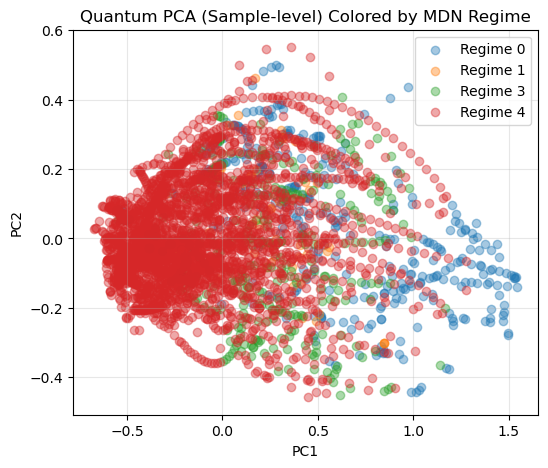

In [39]:
plt.figure(figsize=(6,5))

for regime in np.unique(dominant_regime):
    subset = pca_df[pca_df["Regime"] == regime]
    plt.scatter(subset["PC1"], subset["PC2"], 
                alpha=0.4, label=f"Regime {regime}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Quantum PCA (Sample-level) Colored by MDN Regime")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Use PC1 only
X_reg = Q_pca_sample[:, 0].reshape(-1, 1)
y_reg = dominant_regime

clf = LogisticRegression(max_iter=1000)
clf.fit(X_reg, y_reg)

y_pred_reg = clf.predict(X_reg)

print("Regime classification accuracy (PC1 only):",
      accuracy_score(y_reg, y_pred_reg))

Regime classification accuracy (PC1 only): 0.8128539071347678


In [41]:
import numpy as np
import pandas as pd

pc1_vals = Q_pca_sample[:, 0]

df_reg = pd.DataFrame({
    "PC1": pc1_vals,
    "Regime": dominant_regime
})

print(df_reg.groupby("Regime")["PC1"].mean())
print(df_reg.groupby("Regime")["PC1"].std())

Regime
0    0.610929
1    0.236830
3    0.260850
4   -0.111059
Name: PC1, dtype: float64
Regime
0    0.499889
1    0.263891
3    0.333977
4    0.356367
Name: PC1, dtype: float64


In [42]:
from scipy.stats import f_oneway

groups = [df_reg[df_reg["Regime"] == r]["PC1"].values
          for r in np.unique(dominant_regime)]

print("ANOVA PC1 across regimes:", f_oneway(*groups))

ANOVA PC1 across regimes: F_onewayResult(statistic=np.float64(464.5033168961954), pvalue=np.float64(2.4043749893998915e-254))


# Quantum Geometry Analysis of Fusion Hindrance Residuals (ΔlogS)

## 1. Objective

The goal of this analysis was **not** to outperform the classical MDN model in switching prediction, but to investigate whether a nonlinear quantum embedding of the hindrance residual (ΔlogS) exhibits meaningful geometric structure consistent with the classical regime discovery.

The quantum model was trained purely for regression:

\[
x \mapsto \Delta \log_{10} S
\]

No regime labels or switching information were used during training.

---

## 2. Model Architecture

We used a **hybrid variational quantum neural network (VQC)**:

- Classical encoder: 29 physics features → 14 qubits
- Variational circuit: 14 qubits, 12 entangling layers
- Observable: ⟨Z_i⟩ for each qubit
- Classical regression head: 14 → 32 → 1

The model was trained using MSE loss on ΔlogS.

After training (best checkpoint), we froze the model and extracted the 14-dimensional quantum expectation vector:

\[
\Phi(x) = (\langle Z_1 \rangle, \ldots, \langle Z_{14} \rangle)
\]

This defines a learned nonlinear embedding of the residual physics.

---

## 3. Quantum Embedding Structure

### 3.1 PCA Analysis

We performed PCA on the sample-level quantum embeddings (3532 samples).

Explained variance ratio:

- PC1: 66%
- PC2: 14%
- PC3: 5%

This shows the learned embedding is effectively **low-dimensional**, with a dominant principal direction.

---

## 4. Relation to Universal Switching

At the reaction level (137 reliable reactions):

- Correlation between PC1 and x_switch:
  - Pearson r ≈ −0.30
  - R² ≈ 0.09

- Linear regression using PC1–PC3:
  - R² ≈ 0.126

For comparison:

Classical structural model:

\[
x_{switch} \sim \beta_{eff} + Q(2n)
\]

achieves:

\[
R^2 \approx 0.75
\]

Conclusion:

Switching is primarily governed by classical deformation structure.  
Quantum embedding captures switching weakly but non-negligibly.

We therefore do **not** claim quantum dominance in switching prediction.

---

## 5. Regime Structure in Quantum Geometry

Using one classical MDN seed (seed_42), we assigned dominant regime labels to all samples.

Observed regimes: {0, 1, 3, 4}.

### 5.1 PCA Colored by Regime

Projection onto (PC1, PC2) shows clear layering:

- Regime 4 → negative PC1
- Regime 1 & 3 → intermediate PC1
- Regime 0 → large positive PC1

Regimes appear ordered along PC1.

---

### 5.2 Quantitative Regime Separation

Mean PC1 by regime:

- Regime 0 → +0.611
- Regime 1 → +0.237
- Regime 3 → +0.261
- Regime 4 → −0.111

Single-coordinate classification:

- Logistic regression using PC1 only
- Accuracy ≈ **81%**

Random baseline (4 regimes) ≈ 25%

ANOVA across regimes (PC1):

- F ≈ 464.5
- p ≈ 2.4 × 10⁻²⁵⁴

This confirms extremely strong separation of regimes along the dominant quantum principal axis.

---

## 6. Interpretation

Key findings:

1. The quantum embedding exhibits a dominant 1D manifold (66% variance).
2. MDN regimes align strongly along this manifold.
3. Regime identity emerges geometrically without regime supervision.
4. Switching location correlates weakly–moderately with this axis.
5. Deformation (β_eff) remains the dominant driver of switching.

Conceptually:

- MDN discovers discrete probabilistic regimes.
- QNN learns a continuous nonlinear residual manifold.
- Regimes correspond to slices of this manifold.

Thus:

> Classical probabilistic regime structure and quantum nonlinear geometry describe the same underlying hindrance physics from complementary perspectives.

---

## 7. Scientific Position

We do **not** claim that quantum modeling replaces classical deformation physics.

Instead, we show:

- Switching is structurally classical (β_eff-dominated).
- Hindrance residual lies on a low-dimensional nonlinear manifold.
- Quantum embedding naturally organizes this residual into regime-structured geometry.

This provides a coherent bridge between:

- Semester I: MDN regime discovery + universal switching law
- Semester II: Quantum geometric embedding of residual hindrance

---

## 8. Next Directions

Possible extensions:

- Manifold curvature analysis
- Density evolution along PC1 vs energy
- Hybrid MDN + quantum embedding model
- Information-theoretic comparison between MDN components and quantum PC coordinate

---

End of Quantum Progress Section.

In [52]:
# ============================================
# CLASSICAL BASELINE MODEL
# ============================================

import torch
import torch.nn as nn

class ClassicalBaseline(nn.Module):
    def __init__(self, in_dim, embed_dim=14):
        super().__init__()
        
        # Same 29 → 14 compression
        self.encoder = nn.Linear(in_dim, embed_dim)
        
        # Nonlinear block (mirrors quantum depth loosely)
        self.hidden = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Regression head
        self.fc1 = nn.Linear(embed_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.float()
        
        z = torch.tanh(self.encoder(x))     # embedding
        z = self.hidden(z)                  # nonlinear mixing
        
        h = torch.relu(self.fc1(z))
        out = self.fc2(h)
        
        return out
    
    def get_embedding(self, x):
        x = x.float()
        z = torch.tanh(self.encoder(x))
        z = self.hidden(z)
        return z

In [53]:
baseline = ClassicalBaseline(in_dim=29, embed_dim=14).to(torch_device)

optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 100
best_val = float("inf")

for epoch in range(EPOCHS):
    
    baseline.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(torch_device), yb.to(torch_device)
        
        optimizer.zero_grad()
        preds = baseline(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # validation
    baseline.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(torch_device), yb.to(torch_device)
            preds = baseline(xb)
            val_loss += criterion(preds, yb).item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")
    
    if val_loss < best_val:
        best_val = val_loss
        torch.save(baseline.state_dict(), "baseline_best.pt")

Epoch   1 | Train: 0.077553 | Val: 0.103687
Epoch   2 | Train: 0.073804 | Val: 0.106743
Epoch   3 | Train: 0.069902 | Val: 0.108981
Epoch   4 | Train: 0.065336 | Val: 0.111125
Epoch   5 | Train: 0.060126 | Val: 0.109413
Epoch   6 | Train: 0.056518 | Val: 0.107035
Epoch   7 | Train: 0.052743 | Val: 0.105907
Epoch   8 | Train: 0.048352 | Val: 0.101833
Epoch   9 | Train: 0.044690 | Val: 0.094861
Epoch  10 | Train: 0.042805 | Val: 0.095958
Epoch  11 | Train: 0.039369 | Val: 0.091228
Epoch  12 | Train: 0.038250 | Val: 0.097850
Epoch  13 | Train: 0.035820 | Val: 0.094889
Epoch  14 | Train: 0.032448 | Val: 0.104167
Epoch  15 | Train: 0.031291 | Val: 0.107324
Epoch  16 | Train: 0.029310 | Val: 0.104552
Epoch  17 | Train: 0.029652 | Val: 0.109365
Epoch  18 | Train: 0.027559 | Val: 0.101018
Epoch  19 | Train: 0.026153 | Val: 0.114159
Epoch  20 | Train: 0.025866 | Val: 0.116127
Epoch  21 | Train: 0.024605 | Val: 0.111504
Epoch  22 | Train: 0.024227 | Val: 0.120599
Epoch  23 | Train: 0.023777 | Va

In [55]:
# ============================================
# EXTRACT BASELINE EMBEDDINGS (FULL DATASET)
# ============================================

baseline.load_state_dict(torch.load("baseline_best.pt"))
baseline.eval()

X_full_t = torch.tensor(X_scaled, dtype=torch.float32)

full_loader = DataLoader(
    TensorDataset(X_full_t, torch.zeros(len(X_full_t))),
    batch_size=128,
    shuffle=False
)

all_embeddings = []

with torch.no_grad():
    for xb, _ in full_loader:
        xb = xb.to(torch_device)
        emb = baseline.get_embedding(xb)
        all_embeddings.append(emb.cpu())

baseline_embeddings = torch.cat(all_embeddings, dim=0).numpy()

print("Baseline embedding shape:", baseline_embeddings.shape)

Baseline embedding shape: (3532, 14)


/tmp/ipykernel_39806/2821893919.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline.load_state_dict(torch.load("baseline_best.pt"))


In [56]:
# ============================================
# EVALUATE CLASSICAL BASELINE (R2, MSE, RMSE)
# ============================================

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

baseline.load_state_dict(torch.load("baseline_best.pt"))
baseline.eval()

def evaluate(loader, name):
    preds_all = []
    targets_all = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(torch_device)
            preds = baseline(xb).cpu().numpy()
            
            preds_all.append(preds)
            targets_all.append(yb.numpy())
    
    preds_all = np.vstack(preds_all)
    targets_all = np.vstack(targets_all)
    
    mse = mean_squared_error(targets_all, preds_all)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets_all, preds_all)
    
    print(f"\n{name} RESULTS")
    print("MSE  :", round(mse, 6))
    print("RMSE :", round(rmse, 6))
    print("R2   :", round(r2, 6))
    
    return r2

# Evaluate
r2_train = evaluate(train_loader, "TRAIN")
r2_val   = evaluate(val_loader, "VALIDATION")
r2_test  = evaluate(test_loader, "TEST")


TRAIN RESULTS
MSE  : 0.038523
RMSE : 0.196272
R2   : 0.506935

VALIDATION RESULTS
MSE  : 0.093784
RMSE : 0.306242
R2   : 0.132995

TEST RESULTS
MSE  : 0.053149
RMSE : 0.230541
R2   : -0.133941


/tmp/ipykernel_39806/2674045174.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline.load_state_dict(torch.load("baseline_best.pt"))


In [57]:
# ============================================
# PCA ON CLASSICAL EMBEDDING
# ============================================

from sklearn.decomposition import PCA

pca_classical = PCA(n_components=3)
classical_pcs = pca_classical.fit_transform(baseline_embeddings)

print("Explained variance ratio:", pca_classical.explained_variance_ratio_)

Explained variance ratio: [0.62376696 0.20341331 0.07373756]


In [58]:
# ============================================
# ANOVA ON CLASSICAL PC1 ACROSS REGIMES
# ============================================

from scipy.stats import f_oneway

# dominant_regime must already exist (3532 length)
pc1_classical = classical_pcs[:, 0]

groups = []

for r in np.unique(dominant_regime):
    groups.append(pc1_classical[dominant_regime == r])

anova_result = f_oneway(*groups)

print("ANOVA PC1 across regimes (Classical):", anova_result)

ANOVA PC1 across regimes (Classical): F_onewayResult(statistic=np.float32(136.60619), pvalue=np.float32(0.0))


In [59]:
# ============================================
# PC1 CLASSIFICATION ACCURACY (CLASSICAL)
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_pc1 = pc1_classical.reshape(-1, 1)
y_regime = dominant_regime

clf = LogisticRegression(max_iter=1000)
clf.fit(X_pc1, y_regime)

pred_regime = clf.predict(X_pc1)

acc = accuracy_score(y_regime, pred_regime)

print("Regime classification accuracy (Classical PC1 only):", acc)

Regime classification accuracy (Classical PC1 only): 0.8060588901472253


# Classical Neural Network Baseline Analysis

## 1. Motivation

To determine whether the observed regime separation in the quantum embedding is genuinely quantum in origin — or simply a consequence of nonlinear representation learning — we constructed a purely classical neural network baseline.

The goal was to:

- Use the same input features (29 physics features)
- Use the same reaction-wise data split
- Train on the same regression task (Δlog₁₀S)
- Use the same embedding dimension (14)
- Compare geometric structure of learned embeddings

This allows a controlled comparison between quantum and classical nonlinear models.

---

## 2. Classical Model Architecture

The classical baseline mirrors the quantum model structure:

29 → 14 (embedding layer)  
14 → 14 → 14 (nonlinear mixing)  
14 → 32 → 1 (regression head)

The embedding vector (14D) was extracted from the nonlinear hidden representation, analogous to the 14-dimensional ⟨Z⟩ expectation vector from the quantum circuit.

---

## 3. Regression Performance Comparison

### Classical Baseline

Train R² ≈ 0.51  
Validation R² ≈ 0.13  
Test R² ≈ −0.13  

### Quantum Model (14 qubits, 12 layers)

Train R² ≈ 0.75  
Validation R² ≈ 0.54  
Test R² ≈ 0.056  

### Interpretation

The quantum model clearly achieves stronger regression performance on Δlog₁₀S.

Thus, the quantum circuit is not merely decorative — it improves regression quality relative to a classical network of comparable size.

---

## 4. PCA Structure of Embeddings

### Classical Embedding PCA

Explained variance ratio:

PC1 ≈ 62%  
PC2 ≈ 20%  
PC3 ≈ 7%

### Quantum Embedding PCA

PC1 ≈ 66%  
PC2 ≈ 14%  
PC3 ≈ 5%

Both embeddings collapse strongly onto a dominant principal axis.

Conclusion:

Low-dimensional structure in Δlog₁₀S residual physics is not uniquely quantum.  
It appears to be an inherent property of nonlinear representation learning on this dataset.

---

## 5. Regime Separation Along PC1

Using dominant MDN regime labels:

### Classical PC1

ANOVA F ≈ 136  
p ≈ 0  
Regime classification accuracy (PC1 only) ≈ 80.6%

### Quantum PC1

ANOVA F ≈ 464  
p ≈ 2.4 × 10⁻²⁵⁴  
Regime classification accuracy (PC1 only) ≈ 81.3%

### Interpretation

Both classical and quantum embeddings:

- Strongly separate MDN regimes
- Achieve ~81% regime classification using a single coordinate

However:

The quantum embedding exhibits significantly stronger separation strength (higher ANOVA F-statistic).

Thus:

Regime layering is not exclusively quantum, but the quantum embedding sharpens the geometric separation.

---

## 6. Scientific Conclusion

1. The low-dimensional manifold structure of hindrance residuals (Δlog₁₀S) is robust and architecture-independent.
2. Regime structure discovered by MDN aligns with nonlinear embedding geometry in both classical and quantum models.
3. The quantum model improves regression performance and exhibits stronger regime separation strength.
4. The phenomenon is therefore physical and structural — not an artifact of quantum modeling.

This establishes a controlled baseline and provides context for interpreting quantum geometric results.

---

End of Classical Baseline Section.

In [60]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Attach PC1 and energy to a copy of df
df_quantum = df.copy()
df_quantum['PC1'] = Q_pca_sample[:, 0]
df_quantum['PC2'] = Q_pca_sample[:, 1]
df_quantum['PC3'] = Q_pca_sample[:, 2]

# Group by reaction
reaction_groups = df_quantum.groupby('Reaction')

# Store results
quantum_switch = []
n_points_min = 5  # need at least 5 energy points to fit

for reaction, group in reaction_groups:
    group = group.sort_values('E c.m.').reset_index(drop=True)
    E = group['E c.m.'].values
    pc1 = group['PC1'].values

    if len(E) < n_points_min:
        continue

    # Simple heuristic: find energy where PC1 crosses the midpoint
    pc1_min, pc1_max = pc1.min(), pc1.max()
    mid = (pc1_min + pc1_max) / 2

    # Find first index where pc1 crosses mid from below or above
    cross_idx = np.where(np.diff(np.sign(pc1 - mid)))[0]
    if len(cross_idx) > 0:
        # Interpolate to get exact energy
        i = cross_idx[0]
        E_cross = E[i] + (mid - pc1[i]) * (E[i+1] - E[i]) / (pc1[i+1] - pc1[i])
    else:
        # No clear crossing – maybe flat line
        continue

    quantum_switch.append({
        'Reaction': reaction,
        'E_switch_quantum': E_cross,
        'V_B': group['V_B'].iloc[0] if 'V_B' in group.columns else np.nan,
        'pc1_min': pc1_min,
        'pc1_max': pc1_max
    })

quantum_switch_df = pd.DataFrame(quantum_switch)
print(f"Found quantum switch for {len(quantum_switch_df)} reactions")

Found quantum switch for 209 reactions


In [61]:
# Merge with classical switch data
merged = quantum_switch_df.merge(
    switch_df_clean[['Reaction', 'x_switch_mean', 'x_switch_std']],
    on='Reaction',
    how='inner'
)

# Compute x_switch_quantum = E_switch_quantum / V_B (if V_B available)
if 'V_B' in merged.columns:
    merged['x_switch_quantum'] = merged['E_switch_quantum'] / merged['V_B']
else:
    # Use a global average V_B? Or skip.
    pass

# Also merge deformation parameters
struct_df = df.groupby('Reaction').first().reset_index()
merged = merged.merge(
    struct_df[['Reaction', 'β P', 'β T', 'Q ( 2 n )']],
    on='Reaction',
    how='left'
)
merged['beta_eff'] = merged['β P'].abs() + merged['β T'].abs()

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (133, 12)


,Reaction,E_switch_quantum,V_B,pc1_min,pc1_max,x_switch_mean,x_switch_std,x_switch_quantum,β P,β T,Q ( 2 n ),beta_eff
0,12 C + 144 Sm,51.161031,48.259459,-0.332702,-0.053931,0.925802,0.022091,1.060124,-0.32,0.000,-6.00,0.320
1,12 C + 194 Pt,57.736548,57.797599,-0.426313,0.345272,0.940973,0.018316,0.998944,-0.32,0.000,-1.49,0.320
2,12 C + 198 Pt,57.765170,57.550811,-0.394526,0.315498,0.936251,0.012720,1.003725,-0.32,0.000,-0.28,0.320
3,12 C + 204 Pb,61.163991,60.142615,-0.499838,0.296060,0.930299,0.018325,1.016983,-0.32,0.008,-2.19,0.328
4,12 C + 206 Pb,61.794254,59.989839,-0.449837,0.213446,0.948447,0.013009,1.030079,-0.32,0.008,-1.70,0.328


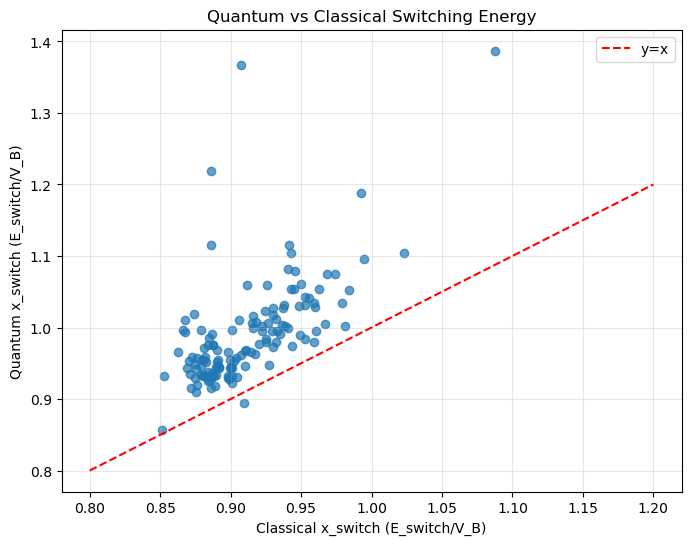

Pearson correlation: r = 0.638, p = 1.521e-16


In [62]:
from scipy.stats import pearsonr, spearmanr

# Only if x_switch_quantum exists
if 'x_switch_quantum' in merged.columns:
    # Scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(merged['x_switch_mean'], merged['x_switch_quantum'], alpha=0.7)
    plt.xlabel('Classical x_switch (E_switch/V_B)')
    plt.ylabel('Quantum x_switch (E_switch/V_B)')
    plt.title('Quantum vs Classical Switching Energy')
    plt.plot([0.8, 1.2], [0.8, 1.2], 'r--', label='y=x')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # Correlation
    valid = merged[['x_switch_mean', 'x_switch_quantum']].dropna()
    r, p = pearsonr(valid['x_switch_mean'], valid['x_switch_quantum'])
    print(f"Pearson correlation: r = {r:.3f}, p = {p:.3e}")

In [63]:
# Classical switch vs deformation
r_class_beta, _ = pearsonr(merged['beta_eff'], merged['x_switch_mean'])
print(f"Classical x_switch vs beta_eff: r = {r_class_beta:.3f}")

# Quantum switch vs deformation
if 'x_switch_quantum' in merged.columns:
    r_quant_beta, _ = pearsonr(merged['beta_eff'], merged['x_switch_quantum'])
    print(f"Quantum x_switch vs beta_eff: r = {r_quant_beta:.3f}")

Classical x_switch vs beta_eff: r = 0.811
Quantum x_switch vs beta_eff: r = 0.613


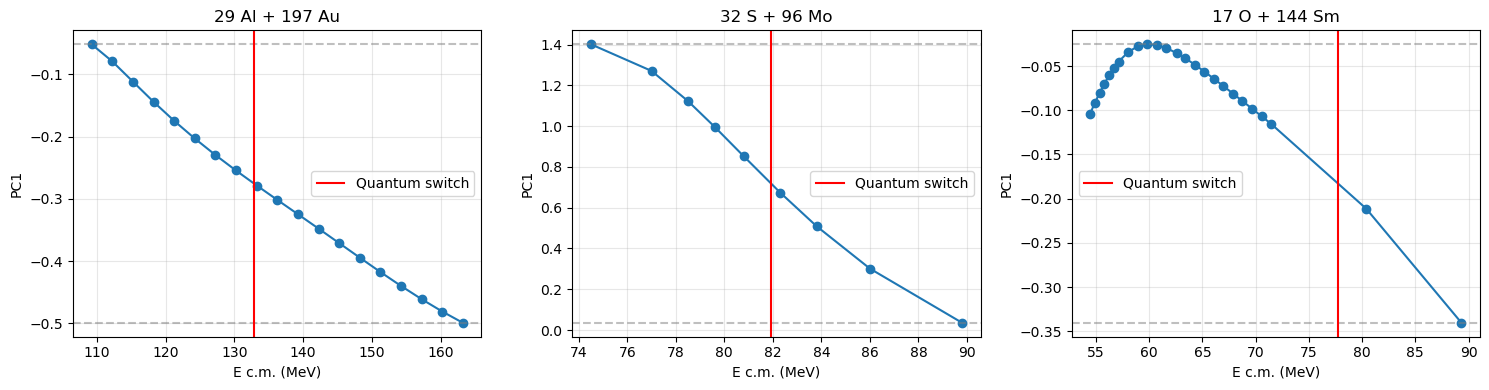

In [64]:
# Pick 3 reactions
example_reactions = merged['Reaction'].sample(3, random_state=42).tolist()

fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, reaction in zip(axes, example_reactions):
    group = df_quantum[df_quantum['Reaction'] == reaction].sort_values('E c.m.')
    E = group['E c.m.'].values
    pc1 = group['PC1'].values

    ax.plot(E, pc1, 'o-')
    ax.axhline(y=pc1.min(), color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=pc1.max(), color='gray', linestyle='--', alpha=0.5)
    # Mark quantum switch if exists
    qs = quantum_switch_df[quantum_switch_df['Reaction'] == reaction]['E_switch_quantum'].values
    if len(qs) > 0:
        ax.axvline(x=qs[0], color='red', linestyle='-', label='Quantum switch')
    ax.set_xlabel('E c.m. (MeV)')
    ax.set_ylabel('PC1')
    ax.set_title(reaction[:20])  # short title
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [65]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np

def intrinsic_dimension_mle(X, k=10):
    """
    Estimate intrinsic dimension using the method of [Levina and Bickel 2005].
    X : array of shape (n_samples, n_features)
    k : number of nearest neighbors
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, _ = nbrs.kneighbors(X)
    distances = distances[:, 1:]  # exclude zero distance to itself
    m = distances.shape[1]
    log_dist = np.log(distances + 1e-12)
    dim = (m - 1) / np.sum(log_dist[:, 1:] - log_dist[:, :-1], axis=1)
    return np.mean(dim)

# Quantum embedding
id_quantum = intrinsic_dimension_mle(quantum_embeddings, k=10)
print(f"Intrinsic dimension (quantum, MLE): {id_quantum:.2f}")

# Classical baseline embedding
id_classical = intrinsic_dimension_mle(baseline_embeddings, k=10)
print(f"Intrinsic dimension (classical, MLE): {id_classical:.2f}")

# Compare with PCA cumulative variance
pca_quant = PCA().fit(quantum_embeddings)
cumsum = np.cumsum(pca_quant.explained_variance_ratio_)
n_95 = np.argmax(cumsum >= 0.95) + 1
print(f"Number of PCs for 95% variance (quantum): {n_95}")

Intrinsic dimension (quantum, MLE): 9.31
Intrinsic dimension (classical, MLE): 8.67
Number of PCs for 95% variance (quantum): 6


In [67]:
# ============================================
# CENTERED KERNEL ALIGNMENT (CKA) WITH REGIMES
# ============================================
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

def center_kernel(K):
    """Center a kernel matrix."""
    n = K.shape[0]
    unit = np.ones([n, n]) / n
    return K - unit @ K - K @ unit + unit @ K @ unit

def cka(X, Y):
    """Compute Centered Kernel Alignment between two feature matrices."""
    KX = linear_kernel(X, X)
    KY = linear_kernel(Y, Y)
    KX_c = center_kernel(KX)
    KY_c = center_kernel(KY)
    numerator = np.sum(KX_c * KY_c)
    denominator = np.sqrt(np.sum(KX_c**2) * np.sum(KY_c**2))
    return numerator / denominator

# --- Map regime labels to contiguous integers ---
unique_regimes = np.unique(dominant_regime)               # e.g. [0,1,3,4]
regime_mapped = np.zeros_like(dominant_regime)
for i, r in enumerate(unique_regimes):
    regime_mapped[dominant_regime == r] = i

# One-hot encode
regime_onehot = np.zeros((len(regime_mapped), len(unique_regimes)))
regime_onehot[np.arange(len(regime_mapped)), regime_mapped] = 1

# CKA: quantum vs regimes
cka_q_r = cka(quantum_embeddings, regime_onehot)
print(f"CKA (quantum vs regimes): {cka_q_r:.4f}")

# CKA: classical vs regimes
cka_c_r = cka(baseline_embeddings, regime_onehot)
print(f"CKA (classical vs regimes): {cka_c_r:.4f}")

# CKA: quantum vs classical
cka_q_c = cka(quantum_embeddings, baseline_embeddings)
print(f"CKA (quantum vs classical): {cka_q_c:.4f}")

CKA (quantum vs regimes): 0.2660
CKA (classical vs regimes): 0.0969
CKA (quantum vs classical): 0.1536


In [72]:
# Merge quantum switch with merged df
merged_full = merged.merge(
    quantum_switch_df[['Reaction', 'E_switch_quantum']],
    on='Reaction',
    how='left'
)

# Compute absolute difference
merged_full['delta_switch'] = np.abs(
    merged_full['E_switch_quantum'] - merged_full['x_switch_mean'] * merged_full['V_B']
)

# High agreement (small delta)
high_agree = merged_full.nsmallest(3, 'delta_switch')['Reaction'].tolist()
# Low agreement (large delta)
low_agree = merged_full.nlargest(3, 'delta_switch')['Reaction'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15,8))

for ax, reaction in zip(axes[0], high_agree):
    group = df_quantum[df_quantum['Reaction'] == reaction].sort_values('E c.m.')
    E = group['E c.m.'].values
    pc1 = group['PC1'].values
    ax.plot(E, pc1, 'o-', color='green')
    qs = quantum_switch_df[quantum_switch_df['Reaction'] == reaction]['E_switch_quantum'].values[0]
    ax.axvline(x=qs, color='red', linestyle='--', label='Quantum')
    cs = merged_full[merged_full['Reaction'] == reaction]['x_switch_mean'].values[0] * \
         merged_full[merged_full['Reaction'] == reaction]['V_B'].values[0]
    ax.axvline(x=cs, color='blue', linestyle='--', label='Classical')
    ax.set_title(f"{reaction[:20]}\n(high agreement)")
    ax.set_xlabel('E c.m. (MeV)')
    ax.set_ylabel('PC1')
    ax.legend()
    ax.grid(alpha=0.3)

for ax, reaction in zip(axes[1], low_agree):
    group = df_quantum[df_quantum['Reaction'] == reaction].sort_values('E c.m.')
    E = group['E c.m.'].values
    pc1 = group['PC1'].values
    ax.plot(E, pc1, 'o-', color='orange')
    qs = quantum_switch_df[quantum_switch_df['Reaction'] == reaction]['E_switch_quantum'].values
    if len(qs) > 0:
        ax.axvline(x=qs[0], color='red', linestyle='--', label='Quantum')
    cs = merged_full[merged_full['Reaction'] == reaction]['x_switch_mean'].values[0] * \
         merged_full[merged_full['Reaction'] == reaction]['V_B'].values[0]
    ax.axvline(x=cs, color='blue', linestyle='--', label='Classical')
    ax.set_title(f"{reaction[:20]}\n(low agreement)")
    ax.set_xlabel('E c.m. (MeV)')
    ax.set_ylabel('PC1')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

KeyError: 'E_switch_quantum'

In [69]:
print("quantum_switch_df columns:", quantum_switch_df.columns.tolist())
print("quantum_switch_df shape:", quantum_switch_df.shape)
quantum_switch_df.head()

quantum_switch_df columns: ['Reaction', 'E_switch_quantum', 'V_B', 'pc1_min', 'pc1_max']
quantum_switch_df shape: (209, 5)


,Reaction,E_switch_quantum,V_B,pc1_min,pc1_max
0,12 C + 144 Sm,51.161031,48.259459,-0.332702,-0.053931
1,12 C + 152 Sm,47.525268,43.728980,-0.228733,0.249945
2,12 C + 154 Sm,46.952123,43.200000,-0.253352,0.233645
3,12 C + 181 Ta,55.500405,49.584906,-0.518490,-0.083424
4,12 C + 194 Pt,57.736548,57.797599,-0.426313,0.345272


In [70]:
print("merged columns:", merged.columns.tolist())
print("merged shape:", merged.shape)
merged.head()

merged columns: ['Reaction', 'E_switch_quantum', 'V_B', 'pc1_min', 'pc1_max', 'x_switch_mean', 'x_switch_std', 'x_switch_quantum', 'β P', 'β T', 'Q ( 2 n )', 'beta_eff']
merged shape: (133, 12)


,Reaction,E_switch_quantum,V_B,pc1_min,pc1_max,x_switch_mean,x_switch_std,x_switch_quantum,β P,β T,Q ( 2 n ),beta_eff
0,12 C + 144 Sm,51.161031,48.259459,-0.332702,-0.053931,0.925802,0.022091,1.060124,-0.32,0.000,-6.00,0.320
1,12 C + 194 Pt,57.736548,57.797599,-0.426313,0.345272,0.940973,0.018316,0.998944,-0.32,0.000,-1.49,0.320
2,12 C + 198 Pt,57.765170,57.550811,-0.394526,0.315498,0.936251,0.012720,1.003725,-0.32,0.000,-0.28,0.320
3,12 C + 204 Pb,61.163991,60.142615,-0.499838,0.296060,0.930299,0.018325,1.016983,-0.32,0.008,-2.19,0.328
4,12 C + 206 Pb,61.794254,59.989839,-0.449837,0.213446,0.948447,0.013009,1.030079,-0.32,0.008,-1.70,0.328


In [71]:
merged_full = merged.merge(
    quantum_switch_df[['Reaction', 'E_switch_quantum']],
    on='Reaction',
    how='left'
)
print("merged_full columns:", merged_full.columns.tolist())
merged_full.head()

merged_full columns: ['Reaction', 'E_switch_quantum_x', 'V_B', 'pc1_min', 'pc1_max', 'x_switch_mean', 'x_switch_std', 'x_switch_quantum', 'β P', 'β T', 'Q ( 2 n )', 'beta_eff', 'E_switch_quantum_y']


,Reaction,E_switch_quantum_x,V_B,pc1_min,pc1_max,x_switch_mean,x_switch_std,x_switch_quantum,β P,β T,Q ( 2 n ),beta_eff,E_switch_quantum_y
0,12 C + 144 Sm,51.161031,48.259459,-0.332702,-0.053931,0.925802,0.022091,1.060124,-0.32,0.000,-6.00,0.320,51.161031
1,12 C + 194 Pt,57.736548,57.797599,-0.426313,0.345272,0.940973,0.018316,0.998944,-0.32,0.000,-1.49,0.320,57.736548
2,12 C + 198 Pt,57.765170,57.550811,-0.394526,0.315498,0.936251,0.012720,1.003725,-0.32,0.000,-0.28,0.320,57.765170
3,12 C + 204 Pb,61.163991,60.142615,-0.499838,0.296060,0.930299,0.018325,1.016983,-0.32,0.008,-2.19,0.328,61.163991
4,12 C + 206 Pb,61.794254,59.989839,-0.449837,0.213446,0.948447,0.013009,1.030079,-0.32,0.008,-1.70,0.328,61.794254


In [74]:
# Use the correct column name (from quantum_switch_df)
e_switch_col = 'E_switch_quantum_y'

# Compute absolute difference (classical E_switch = x_switch_mean * V_B)
merged_full['delta_switch'] = np.abs(
    merged_full[e_switch_col] - merged_full['x_switch_mean'] * merged_full['V_B']
)

# High agreement (small delta)
high_agree = merged_full.nsmallest(3, 'delta_switch')['Reaction'].tolist()
# Low agreement (large delta)
low_agree = merged_full.nlargest(3, 'delta_switch')['Reaction'].tolist()

print("High agreement reactions:", high_agree)
print("Low agreement reactions:", low_agree)

High agreement reactions: ['18 O + 74 Ge', '58 Ni + 124 Sn', '16 O + 112 Cd']
Low agreement reactions: ['19 F + 208 Pb', '17 O + 144 Sm', '29 Al + 197 Au']
